In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, \
accuracy_score, recall_score, precision_score, f1_score, log_loss, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv('Terry_stops_cleaned.csv')
df.head()

,subject_age_group,stop_resolution,weapon_type,officer_id,officer_age,officer_gender,officer_race,subject_perceived_race,subject_perceived_gender,reported_date,...,final_call_type,call_type,officer_squad,arrest_flag,frisk_flag,precinct,sector,beat,year,month
0,Not Specified,Arrest,None,7500,37,M,Black or African American,Asian,Male,2015-10-16,...,NaN,NaN,SOUTH PCT 1ST W - ROBERT,0,0,South,O,O2,2015,10
1,Not Specified,Field Contact,None,5670,56,M,White,Unknown,Unknown,2015-03-19,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,2015,3
2,Not Specified,Field Contact,None,7539,58,M,White,Unknown,Unknown,2015-04-01,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,2015,4
3,Not Specified,Field Contact,None,6973,44,M,White,Black or African American,Male,2015-04-03,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,2015,4
4,Not Specified,Field Contact,None,7402,48,M,White,Black or African American,Male,2015-04-05,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,2015,4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48012 entries, 0 to 48011
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   subject_age_group         48012 non-null  object
 1   stop_resolution           48012 non-null  object
 2   weapon_type               48012 non-null  object
 3   officer_id                48012 non-null  int64 
 4   officer_age               48012 non-null  int64 
 5   officer_gender            48012 non-null  object
 6   officer_race              48012 non-null  object
 7   subject_perceived_race    48012 non-null  object
 8   subject_perceived_gender  48012 non-null  object
 9   reported_date             48012 non-null  object
 10  initial_call_type         35004 non-null  object
 11  final_call_type           35004 non-null  object
 12  call_type                 35004 non-null  object
 13  officer_squad             47452 non-null  object
 14  arrest_flag           

In [4]:
# datatype conversions did not stick so reformatting
df['year'] = df['year'].astype('object')
df['month'] = df['month'].astype('object')
df['frisk_flag'] = df['frisk_flag'].astype('object')

In [5]:
df.describe()

,officer_id,officer_age,arrest_flag
count,48012.000000,48012.000000,48012.000000
mean,7820.522869,37.813838,0.079772
std,811.070726,8.795616,0.270942
min,2768.000000,23.000000,0.000000
25%,7546.000000,31.000000,0.000000
50%,7774.000000,36.000000,0.000000
75%,8465.000000,43.000000,0.000000
max,8814.000000,75.000000,1.000000


In [6]:
# Inspecting columns
df.columns

Index(['subject_age_group', 'stop_resolution', 'weapon_type', 'officer_id',
       'officer_age', 'officer_gender', 'officer_race',
       'subject_perceived_race', 'subject_perceived_gender', 'reported_date',
       'initial_call_type', 'final_call_type', 'call_type', 'officer_squad',
       'arrest_flag', 'frisk_flag', 'precinct', 'sector', 'beat', 'year',
       'month'],
      dtype='object')

## Prep

Choosing which feature columns I will use for my predictive modeling. I start by checking my target column and notice that I need to address the class imbalance. I create my X and Y variables and perform a train test split and stratify my y variable so the percentage berakdown is similar to the original dataset. I create variables for my categorical and continuous columns and also create the innards of my pipeline. Finally, I create a function that will evaluate a model's performance.

In [7]:
# Choosing columns we will use for predictive modelling
# Separate continuous and categorical columns for pre-processing

cat_columns = ['subject_age_group', 'officer_gender', 'officer_race', 'subject_perceived_race', 
         'subject_perceived_gender', 'arrest_flag','frisk_flag', 'year', 'month']

cont_columns = ['officer_age']

# create new dataframe with selected columns

df = pd.concat([df[cat_columns], df[cont_columns]], axis=1)

In [8]:
# checking %s of yes and no for arrest flag; will have to bootstrap or smote

df['arrest_flag'].value_counts(normalize=True)

0    0.920228
1    0.079772
Name: arrest_flag, dtype: float64

In [9]:
# Create X and y variables

y = df['arrest_flag']
X = df.drop(columns='arrest_flag').copy()

In [10]:
# create the train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [11]:
# check to see if stratify worked

y_train.value_counts(normalize=True)

0    0.920214
1    0.079786
Name: arrest_flag, dtype: float64

In [12]:
# check to see if stratify worked

y_test.value_counts(normalize=True)

0    0.92027
1    0.07973
Name: arrest_flag, dtype: float64

In [13]:
# creating continuous and categorical lists of columns from df

X_train_num = X_train.select_dtypes(np.number)
X_train_cat = X_train.select_dtypes('object')
len(X_train_num.columns), len(X_train_cat.columns)

(1, 8)

In [14]:
#creating the pipeline Innards

numerical_pipeline = Pipeline(steps=[
    ('ss', StandardScaler())
])
                
categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first',
                         sparse=False))
])

trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_train_num.columns),
    ('categorical', categorical_pipeline, X_train_cat.columns),
    ])

In [15]:
# define a function that returns best parameters of the model, scores, and confusion matrix plot
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    
    print(f'best parameters: {model.best_params_}')
    print('')
    print(classification_report(y, y_pred))
    
    plot_confusion_matrix(model, X, y)

## Modelling

I start off with a baseline model to use as a comparison point with the rest of my models. I decide to use Logistic Regression, KNearestNeighbors, RandomForest, and DecisionTree models. For each model, I add the model to my premade pipeline, created a list of parameters, and ran the pipeline through a grid search. I also print the train and test scores of every model with my evaluate model function.

In [46]:
#Initial baseline model

dummy_clf = DummyClassifier(strategy="most_frequent") 
# look at diff strategies
dummy_clf.fit(X_train, y_train)
dummy_clf.predict(X_train)
dummy_clf_train_score = dummy_clf.score(X_train, y_train)
dummy_clf_test_score = dummy_clf.score(X_test, y_test)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     33136
           1       0.00      0.00      0.00      2873

    accuracy                           0.92     36009
   macro avg       0.46      0.50      0.48     36009
weighted avg       0.85      0.92      0.88     36009



C:\Users\Jesus Baquiax\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


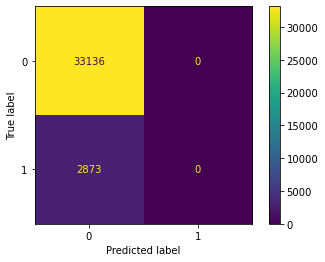

In [17]:
#dummy train score

dummy_y_pred = dummy_clf.predict(X_train)
print(classification_report(y_train, dummy_y_pred))
print(plot_confusion_matrix(dummy_clf, X_train, y_train))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     11046
           1       0.00      0.00      0.00       957

    accuracy                           0.92     12003
   macro avg       0.46      0.50      0.48     12003
weighted avg       0.85      0.92      0.88     12003



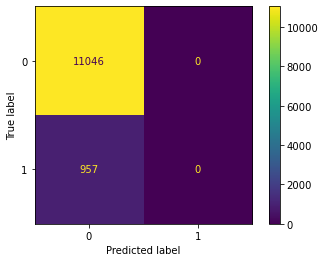

In [18]:
# dummy test score
dummy_y_pred = dummy_clf.predict(X_test)
print(classification_report(y_test, dummy_y_pred))
print(plot_confusion_matrix(dummy_clf, X_test, y_test))

DummyClassifer Model has an accuracy score of 92% which is good, but since there is a class imbalance I'm going to focus on precision, recall, and the f1 score. Another point of concern it the lack of True Positives and False Negatives included in the confusion matrix.

### Logistic Regression Model

In [19]:
logreg_pipeline = Pipeline(steps=[('trans', trans),
                               ('sm',SMOTE()),
                                ('logreg', LogisticRegression())
                              ])

logreg_grid = {'logreg__C': [1, 10], 
               'logreg__penalty': ['l1', 'l2']
              }

In [20]:
logreg_gs = GridSearchCV(estimator=logreg_pipeline, param_grid=logreg_grid)

logreg_gs.fit(X_train, y_train)

C:\Users\Jesus Baquiax\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jesus Baquiax\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jesus Baquiax\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\Jesus Baquiax\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Jesus Baquiax\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supp

C:\Users\Jesus Baquiax\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jesus Baquiax\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jesus Baquiax\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\Jesus Baquiax\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Jesus Baquiax\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supp

C:\Users\Jesus Baquiax\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['officer_age'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         Index(['subject_age_group', 'officer_gender', 

best parameters: {'logreg__C': 1, 'logreg__penalty': 'l2'}

              precision    recall  f1-score   support

           0       1.00      0.77      0.87     33136
           1       0.27      0.98      0.42      2873

    accuracy                           0.79     36009
   macro avg       0.63      0.88      0.65     36009
weighted avg       0.94      0.79      0.83     36009



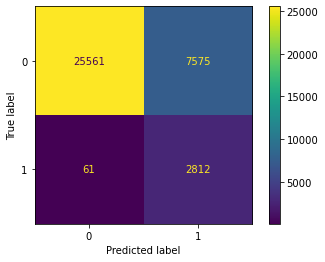

In [21]:
logreg_model_train_score = evaluate_model(logreg_gs, X_train, y_train)

best parameters: {'logreg__C': 1, 'logreg__penalty': 'l2'}

              precision    recall  f1-score   support

           0       1.00      0.77      0.87     11046
           1       0.27      0.98      0.42       957

    accuracy                           0.78     12003
   macro avg       0.63      0.87      0.64     12003
weighted avg       0.94      0.78      0.83     12003



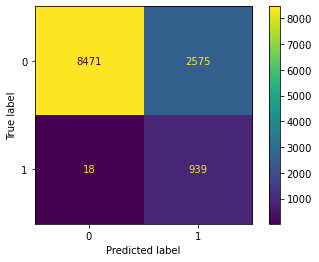

In [22]:
logreg_model_test_score = evaluate_model(logreg_gs, X_test, y_test)

The logistic regression model produced the same f1 scores in the train and test scores which is a good start. I want to see if I can improve on it with other models since the number of false positives in the confusion matrix is still high.

### KNN Model

In [23]:
# knn pipeline
knn_pipeline = Pipeline(steps=[('trans', trans),
                                ('sm',SMOTE()),
                                ('knn', KNeighborsClassifier())])

In [24]:
pipe_grid = {'knn__n_neighbors': [3, 5, 7],
             'knn__p': [1, 2, 3]}

knn_gs = GridSearchCV(estimator=knn_pipeline, param_grid=pipe_grid)
knn_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['officer_age'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         Index(['subject_age_group', 'officer_gender', 

best parameters: {'knn__n_neighbors': 3, 'knn__p': 1}

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     33136
           1       0.62      0.96      0.75      2873

    accuracy                           0.95     36009
   macro avg       0.81      0.95      0.86     36009
weighted avg       0.97      0.95      0.95     36009



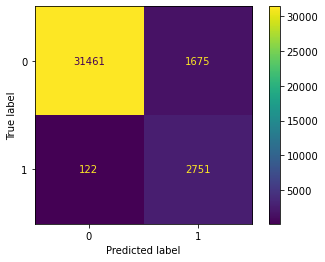

In [25]:
knn_model_train_score = evaluate_model(knn_gs, X_train, y_train)

best parameters: {'knn__n_neighbors': 3, 'knn__p': 1}

              precision    recall  f1-score   support

           0       0.95      0.90      0.93     11046
           1       0.30      0.46      0.36       957

    accuracy                           0.87     12003
   macro avg       0.62      0.68      0.64     12003
weighted avg       0.90      0.87      0.88     12003



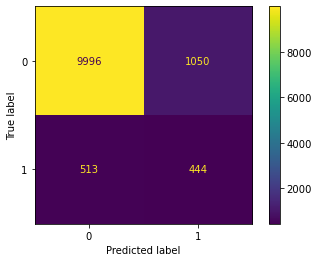

In [26]:
knn_model_test_score = evaluate_model(knn_gs, X_test, y_test)

The KNN model produces a a train precision, recall, and f1 score on the train data set greater than the test data set which indicates that this model is overfitting. The number of false positives has decreased, but the number of false negatives has risen.

### Random Forest Model

In [27]:
rfc_pipeline = Pipeline(steps=[('trans', trans),
                               ('sm',SMOTE()),
                               ('rfc', RandomForestClassifier())])


rfc_grid = {'rfc__max_depth': [4, 5], 'rfc__min_samples_split': [2, 5], 'rfc__min_samples_leaf': [1, 3]}

In [28]:
rfc_gs = GridSearchCV(estimator=rfc_pipeline, param_grid=rfc_grid)

rfc_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['officer_age'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         Index(['subject_age_group', 'officer_gender', 

best parameters: {'rfc__max_depth': 5, 'rfc__min_samples_leaf': 3, 'rfc__min_samples_split': 5}

              precision    recall  f1-score   support

           0       1.00      0.72      0.84     33136
           1       0.24      0.99      0.38      2873

    accuracy                           0.74     36009
   macro avg       0.62      0.86      0.61     36009
weighted avg       0.94      0.74      0.80     36009



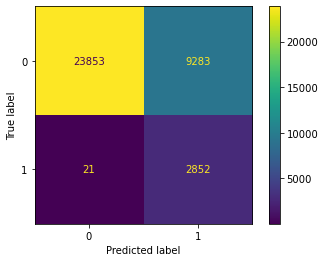

In [29]:
rfc_model_train_score = evaluate_model(rfc_gs, X_train, y_train)

best parameters: {'rfc__max_depth': 5, 'rfc__min_samples_leaf': 3, 'rfc__min_samples_split': 5}

              precision    recall  f1-score   support

           0       1.00      0.71      0.83     11046
           1       0.23      0.99      0.37       957

    accuracy                           0.74     12003
   macro avg       0.61      0.85      0.60     12003
weighted avg       0.94      0.74      0.80     12003



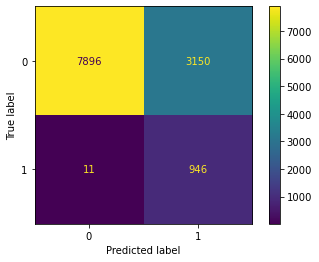

In [30]:
rfc_model_test_score = evaluate_model(rfc_gs, X_test, y_test)

The Random Forest model produced similar precision, recall, and f1 scores in the train and test data sets which is good sign. While the false negatives are significantly lower, the false positives has spiked up from the previous model.

### Decision Tree Model

In [31]:
dtc_pipeline = Pipeline(steps=[('trans', trans),
                               ('sm',SMOTE()),
                                ('dtc', DecisionTreeClassifier())
                              ])

dtc_grid = {'dtc__criterion': ['gini', 'entropy'], 
         'dtc__splitter': ['best', 'random']}

In [32]:
dtc_gs = GridSearchCV(estimator=dtc_pipeline, param_grid=dtc_grid)

dtc_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['officer_age'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         Index(['subject_age_group', 'officer_gender', 

best parameters: {'dtc__criterion': 'gini', 'dtc__splitter': 'random'}

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     33136
           1       0.97      0.86      0.91      2873

    accuracy                           0.99     36009
   macro avg       0.98      0.93      0.95     36009
weighted avg       0.99      0.99      0.99     36009



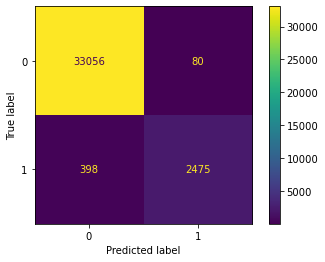

In [33]:
dtc_model_train_score = evaluate_model(dtc_gs, X_train, y_train)

best parameters: {'dtc__criterion': 'gini', 'dtc__splitter': 'random'}

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     11046
           1       0.34      0.36      0.35       957

    accuracy                           0.89     12003
   macro avg       0.64      0.65      0.64     12003
weighted avg       0.90      0.89      0.89     12003



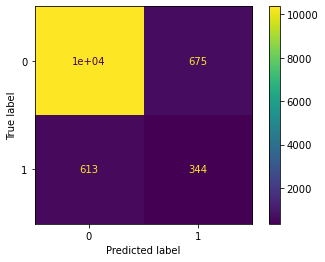

In [34]:
dtc_model_test_score = evaluate_model(dtc_gs, X_test, y_test)

The Decision Tree model produced better precision, recall, and f1 scores on the train set but not the test set. This tends to be the case because the model uses a greedy search approach. However since the train score is greater than the test score this does indicate that the model is overfitting. The false positives and false negatives are much lower than in the previous models.

## Final Model

The Random Forest Model was chosen as the final model because the model didn't overfit between the train and test data sets. The precision, recall and f1 scores are consistent and strong between the train and test data sets as well. 
Below The Random Forest Model was added into a 'best_model' variable and looked at the best estimators from the grid search, the performance of the model using the functions was also reprinted. T he most important features from the model were examined to have a point of reference of where to begin creating my visualizations.

In [35]:
# looked at the best estimators/parameters from the grid search
best_model = rfc_gs.best_estimator_
best_model

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['officer_age'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['subject_age_group', 'officer_gender', 'officer_race',
       'subject_perceived_race', 'subject_perceived_gender', 'frisk_flag',
       'year', 'month'],
      dtype='object'))])),
                ('sm', SMOTE()),
                ('rfc',
                 RandomForestC

best parameters: {'rfc__max_depth': 5, 'rfc__min_samples_leaf': 3, 'rfc__min_samples_split': 5}

              precision    recall  f1-score   support

           0       1.00      0.72      0.84     33136
           1       0.24      0.99      0.38      2873

    accuracy                           0.74     36009
   macro avg       0.62      0.86      0.61     36009
weighted avg       0.94      0.74      0.80     36009



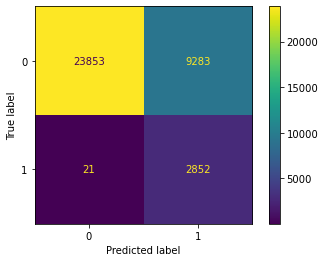

In [36]:
evaluate_model(rfc_gs, X_train, y_train)

best parameters: {'rfc__max_depth': 5, 'rfc__min_samples_leaf': 3, 'rfc__min_samples_split': 5}

              precision    recall  f1-score   support

           0       1.00      0.71      0.83     11046
           1       0.23      0.99      0.37       957

    accuracy                           0.74     12003
   macro avg       0.61      0.85      0.60     12003
weighted avg       0.94      0.74      0.80     12003



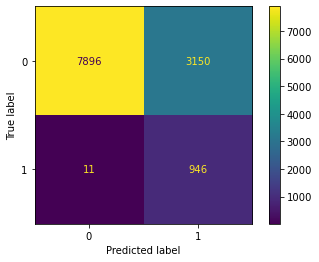

In [37]:
evaluate_model(rfc_gs, X_test, y_test)

In [45]:
# placed the categorical one hot encoded column names into a list from best model and put into a variable
cat_ohe_cols = best_model.named_steps['trans'].named_transformers_['categorical'].named_steps['ohe'].get_feature_names(X_train_cat.columns).tolist()

In [40]:
# combined the OHE categorical column with the continuous columns
feat_cols = [*cont_columns, *cat_ohe_cols]
len(feat_cols)

44

In [47]:
# created a new dataframe using the feat_cols list 
X_train_tf = pd.DataFrame(best_model.named_steps['trans'].fit_transform(X_train), columns=feat_cols)

In [42]:
# added the most important features into a variable
important_feats = pd.Series(best_model.named_steps['rfc'].feature_importances_, 
                           index=feat_cols)

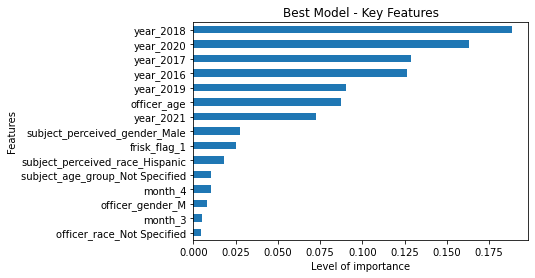

In [44]:
# printed most important features from the model
top_feats = important_feats.sort_values(ascending=False).head(15)
plt.Figure(figsize=(5, 5))
top_feats.sort_values().plot(kind='barh')
plt.xlabel('Level of importance')
plt.ylabel('Features')
plt.title('Best Model - Key Features');